### Import Data

In [1]:
import yfinance as yf
import numpy as np
import pyarrow
import polars as pl
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') 

symbol1 = 'DKNG'
symbol2 = 'FLUT'
symbol3 = 'MGM'

dkng_df = yf.download(symbol1, period='5y', interval='1d')
flut_df = yf.download(symbol2, period='5y', interval='1d')
mgm_df  = yf.download(symbol3, period='5y', interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Save each raw output to CSV

In [2]:
dkng_df.to_csv("dkng_5yr.csv")
flut_df.to_csv("flut_5yr.csv")
mgm_df.to_csv("mgm_5yr.csv")

### Convert to Polars Dataframes

In [3]:
DKNG = pl.read_csv("dkng_5yr.csv", try_parse_dates=True)
FLUT = pl.read_csv("flut_5yr.csv", try_parse_dates=True)
MGM  = pl.read_csv("mgm_5yr.csv" , try_parse_dates=True)

### Calculate Log Returns for Each Stock

In [4]:
# create lag price features
DKNG = DKNG.with_columns(
    pl.col('Close').shift().alias('CloseLag1')
)
FLUT = FLUT.with_columns(
    pl.col('Close').shift().alias('CloseLag1')
)
MGM = MGM.with_columns(
    pl.col('Close').shift().alias('CloseLag1')
)

# log daily returns
DKNG = DKNG.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('DKNG_LogReturn'))
FLUT = FLUT.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('FLUT_LogReturn'))
MGM = MGM.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('MGM_LogReturn'))

### Merge Dataframes Together 

In [5]:
# DKNG_returns = DKNG.select(["Date","DKNG_LogReturn"])
# FLUT_returns = FLUT.select(["Date","FLUT_LogReturn"])
# MGM_returns  = MGM.select( ["Date", "MGM_LogReturn"])

# COMBINED = DKNG_returns.join(FLUT_returns, on="Date")
# COMBINED = COMBINED.join(MGM_returns, on="Date")
# COMBINED = COMBINED.drop_nulls()

DKNG_returns = DKNG.select(["Price","DKNG_LogReturn"])
FLUT_returns = FLUT.select(["Price","FLUT_LogReturn"])
MGM_returns  = MGM.select( ["Price", "MGM_LogReturn"])

COMBINED = DKNG_returns.join(FLUT_returns, on="Price")
COMBINED = COMBINED.join(MGM_returns, on="Price")
COMBINED = COMBINED.drop_nulls()
COMBINED = COMBINED.rename({"Price": "Date"})

COMBINED.write_csv("COMBINED_5yr_log_returns.csv")

### Summary of Each Log Return

In [6]:
print(COMBINED.select(["DKNG_LogReturn","FLUT_LogReturn","MGM_LogReturn"]).describe())

shape: (9, 4)
┌────────────┬────────────────┬────────────────┬───────────────┐
│ statistic  ┆ DKNG_LogReturn ┆ FLUT_LogReturn ┆ MGM_LogReturn │
│ ---        ┆ ---            ┆ ---            ┆ ---           │
│ str        ┆ f64            ┆ f64            ┆ f64           │
╞════════════╪════════════════╪════════════════╪═══════════════╡
│ count      ┆ 1255.0         ┆ 1255.0         ┆ 1255.0        │
│ null_count ┆ 0.0            ┆ 0.0            ┆ 0.0           │
│ mean       ┆ 0.000187       ┆ 0.000644       ┆ 0.000738      │
│ std        ┆ 0.040552       ┆ 0.027573       ┆ 0.026424      │
│ min        ┆ -0.326061      ┆ -0.126518      ┆ -0.141777     │
│ 25%        ┆ -0.023472      ┆ -0.014895      ┆ -0.013897     │
│ 50%        ┆ 0.0            ┆ 0.000593       ┆ 0.00054       │
│ 75%        ┆ 0.02272        ┆ 0.016054       ┆ 0.01492       │
│ max        ┆ 0.159306       ┆ 0.155277       ┆ 0.160903      │
└────────────┴────────────────┴────────────────┴───────────────┘


### Plots

#### Histograms

In [7]:
COMBINED['DKNG_LogReturn'].plot.hist().properties(width=500, title="DKNG Log Return Distribution")

alt.Chart(...)

In [8]:
COMBINED['FLUT_LogReturn'].plot.hist().properties(width=500, title="FLUT Log Return Distribution")

alt.Chart(...)

In [9]:
COMBINED['MGM_LogReturn'].plot.hist().properties(width=500, title="MGM Log Return Distribution")

alt.Chart(...)

#### Line Chart

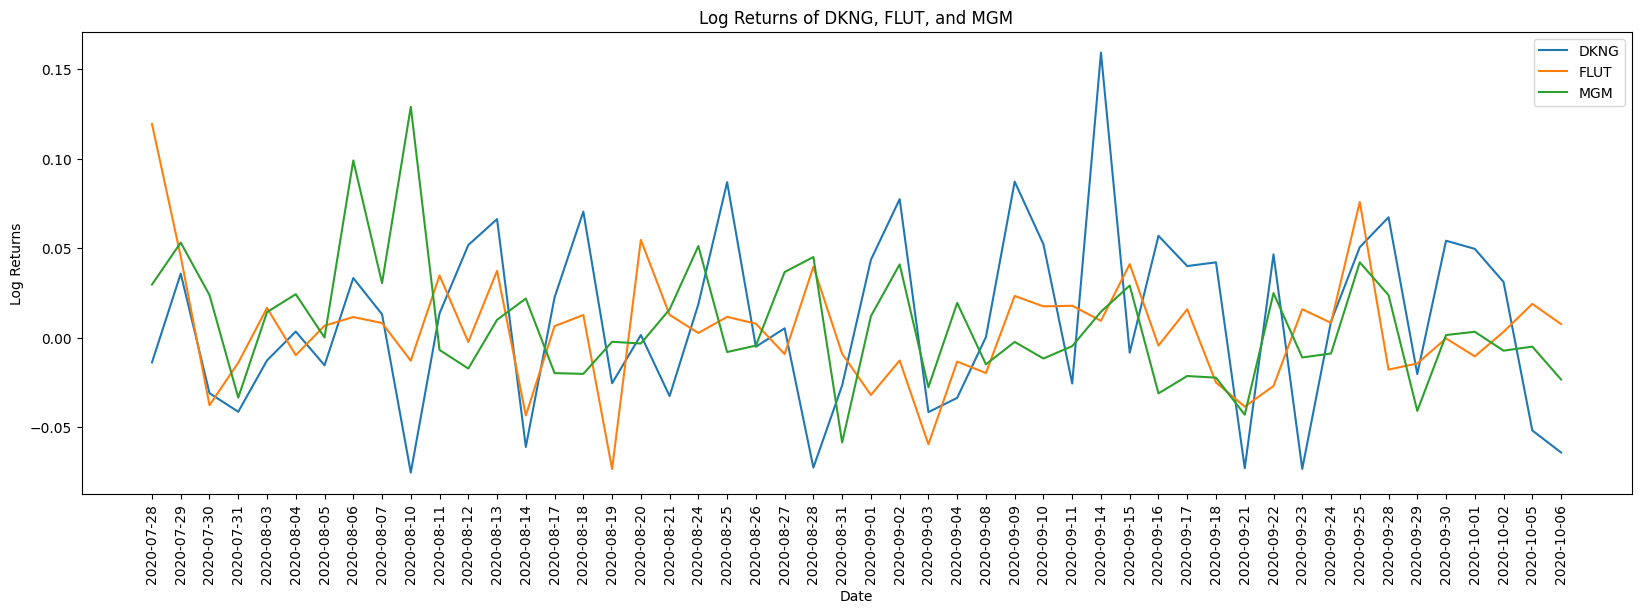

In [10]:
plt.figure(figsize=(20, 6)) 

# Create the line plot
sns.lineplot(x="Date", y="DKNG_LogReturn", data=COMBINED[:50], label="DKNG")
sns.lineplot(x="Date", y="FLUT_LogReturn", data=COMBINED[:50], label="FLUT")
sns.lineplot(x="Date", y="MGM_LogReturn" , data=COMBINED[:50], label="MGM")

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.title("Log Returns of DKNG, FLUT, and MGM")

# rotate labels
plt.xticks(rotation=90)

# Add a legend
plt.legend()

# Display the plot
plt.show()

### Calculate Mean & Standard Deviation for the Log Returns of Each Stock

In [11]:
cols = ['DKNG_LogReturn', 'FLUT_LogReturn', "MGM_LogReturn"]
mean_log_returns = COMBINED.select([pl.col(col).mean() for col in cols])
sd_log_returns = COMBINED.select([pl.col(col).std() for col in cols])
print(mean_log_returns)
print(sd_log_returns)

shape: (1, 3)
┌────────────────┬────────────────┬───────────────┐
│ DKNG_LogReturn ┆ FLUT_LogReturn ┆ MGM_LogReturn │
│ ---            ┆ ---            ┆ ---           │
│ f64            ┆ f64            ┆ f64           │
╞════════════════╪════════════════╪═══════════════╡
│ 0.000187       ┆ 0.000644       ┆ 0.000738      │
└────────────────┴────────────────┴───────────────┘
shape: (1, 3)
┌────────────────┬────────────────┬───────────────┐
│ DKNG_LogReturn ┆ FLUT_LogReturn ┆ MGM_LogReturn │
│ ---            ┆ ---            ┆ ---           │
│ f64            ┆ f64            ┆ f64           │
╞════════════════╪════════════════╪═══════════════╡
│ 0.040552       ┆ 0.027573       ┆ 0.026424      │
└────────────────┴────────────────┴───────────────┘


### Target Correlation of Returns for Generated Data

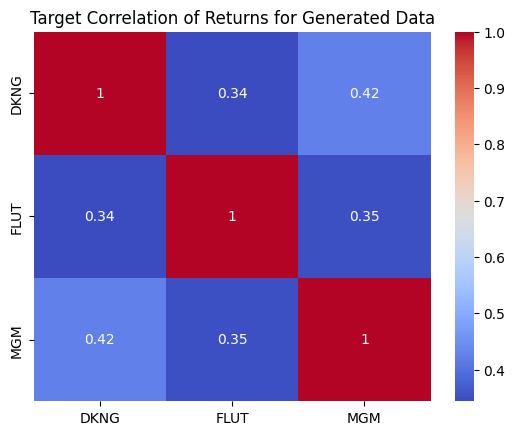

In [12]:
varz = COMBINED.select(["DKNG_LogReturn","FLUT_LogReturn","MGM_LogReturn"])

%matplotlib inline

labels = ['DKNG','FLUT','MGM']
corrMatrix = varz.corr()
sns.heatmap(corrMatrix, cmap='coolwarm', annot=True,
           xticklabels=labels, yticklabels=labels)
plt.title('Target Correlation of Returns for Generated Data', fontsize=12, color='black')

# Display the plot
plt.show()

### Target Covariance of Returns for Generated Data

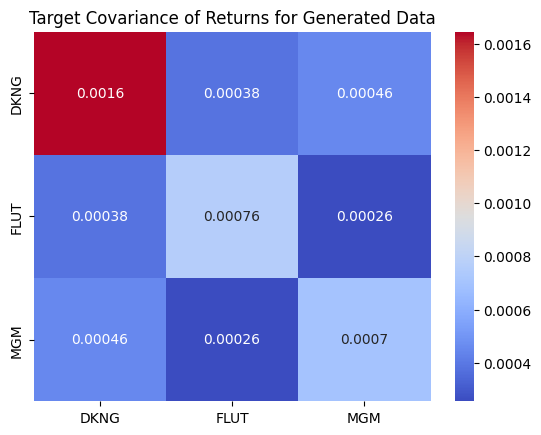

In [13]:
varz_pd = varz.to_pandas()

covMatrix = varz_pd.cov()
sns.heatmap(covMatrix, cmap='coolwarm', annot=True,
           xticklabels=labels, yticklabels=labels)

plt.title('Target Covariance of Returns for Generated Data', fontsize=12, color='black')


plt.show()

### Generate Multivariate Normal Returns

In [14]:
seed = 1111
rng = np.random.default_rng(seed)

sample_size = 1000
means = mean_log_returns.to_numpy().flatten()

returnsData = rng.multivariate_normal(means, covMatrix, size=sample_size)
RETURNS = pl.DataFrame(returnsData, schema=cols)

### Actual Correlation of Returns in Generated Data

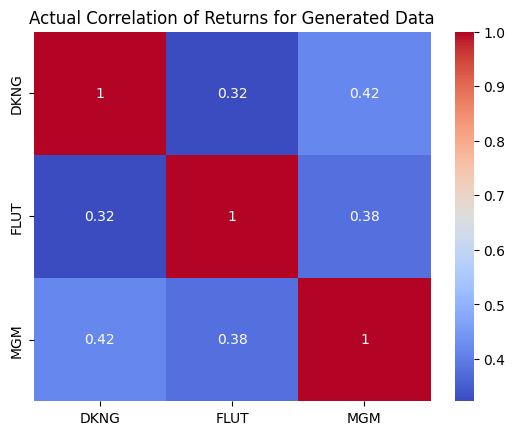

In [15]:
returns_varz = RETURNS.select(["DKNG_LogReturn","FLUT_LogReturn","MGM_LogReturn"])

%matplotlib inline

returns_corrMatrix = returns_varz.corr()
sns.heatmap(returns_corrMatrix, cmap='coolwarm', annot=True,
           xticklabels=labels, yticklabels=labels)

plt.title('Actual Correlation of Returns for Generated Data', fontsize=12, color='black')


plt.show()

### Actual Covariance of Returns in Generated Data

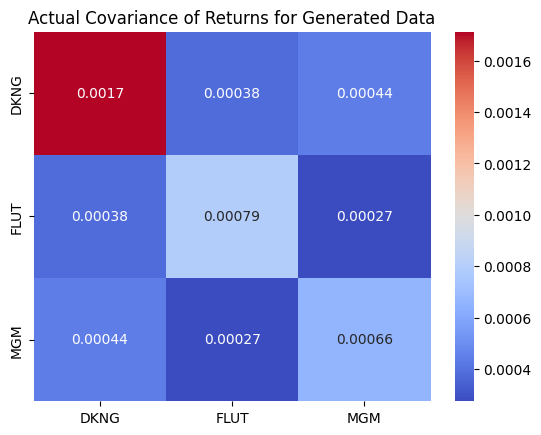

In [16]:
returns_varz_pd = returns_varz.to_pandas()

returns_covMatrix = returns_varz_pd.cov()
sns.heatmap(returns_covMatrix, cmap='coolwarm', annot=True,
           xticklabels=labels, yticklabels=labels)

plt.title('Actual Covariance of Returns for Generated Data', fontsize=12, color='black')


plt.show()

### Generate Random Weights

In [17]:
def makeWeights(shorts=True):
    
    if shorts == True:
        while True:
            x1 = np.random.uniform(-1, 1)
            x2 = np.random.uniform(-1, 1)
            x3 = 1 - x1 - x2
            if -1 <= x3 <= 1:
                return np.array([x1,x2,x3])
    else:
        while True:
            x1 = np.random.uniform(0, 1)
            x2 = np.random.uniform(0, 1)
            x3 = 1 - x1 - x2
            if 0 <= x3 <= 1:
                return np.array([x1,x2,x3])

# matrix with shorts
short_weights = np.empty((0, 3)) 
non_short_weights = np.empty((0, 3)) 

for i in range(sample_size):
    shorts_vector = makeWeights()
    non_shorts_vector = makeWeights(shorts=False)
    short_weights = np.vstack([short_weights,shorts_vector])
    non_short_weights = np.vstack([non_short_weights,non_shorts_vector])
    
weight_cols = ["DKNG_LogReturn_wt","FLUT_LogReturn_wt","MGM_LogReturn_wt"]
short_weights_df = pl.DataFrame(short_weights, schema=weight_cols)
non_short_weights_df = pl.DataFrame(non_short_weights, schema=weight_cols)

### Compute Portfolio Return for each set of weights

#### With Shorts

In [18]:
SHORTS_PORTFOLIO = pl.concat([RETURNS, short_weights_df], how="horizontal")

# mc_mean_log_returns = SHORTS_PORTFOLIO.select([pl.col(col).mean() for col in cols])
# mc_means = mc_mean_log_returns.to_numpy().flatten()

weights_array = short_weights_df.to_numpy()
expected_returns = np.dot(weights_array, means)


def mean_calc(row):
    vec = np.array(
        [row["DKNG_LogReturn_wt"], row["FLUT_LogReturn_wt"], row["MGM_LogReturn_wt"]]
    )
    return np.mean(vec @ means.T)


# SHORTS_PORTFOLIO = SHORTS_PORTFOLIO.with_columns(
#     pl.Series("expected_Return", expected_returns)
# )

SHORTS_PORTFOLIO = SHORTS_PORTFOLIO.with_columns(
    pl.struct(["DKNG_LogReturn_wt", "FLUT_LogReturn_wt", "MGM_LogReturn_wt"])
    .map_elements(mean_calc)
    .alias("expected_Return")
)


def sd_calc(row):
    vec = np.array(
        [row["DKNG_LogReturn_wt"], row["FLUT_LogReturn_wt"], row["MGM_LogReturn_wt"]]
    )
    return np.sqrt(float(vec.T @ returns_covMatrix @ vec))


SHORTS_PORTFOLIO = SHORTS_PORTFOLIO.with_columns(
    pl.struct(["DKNG_LogReturn_wt", "FLUT_LogReturn_wt", "MGM_LogReturn_wt"])
    .map_elements(sd_calc)
    .alias("sd_Return")
)

#### Without Shorts

In [19]:
NO_SHORTS_PORTFOLIO = pl.concat([RETURNS, non_short_weights_df], how="horizontal")

mc_mean_log_returns = NO_SHORTS_PORTFOLIO.select([pl.col(col).mean() for col in cols])
mc_means = mc_mean_log_returns.to_numpy().flatten()

weights_array_no_shorts = non_short_weights_df.to_numpy()
expected_returns_no_shorts = np.dot(weights_array_no_shorts, means)


# NO_SHORTS_PORTFOLIO = NO_SHORTS_PORTFOLIO.with_columns(
#     pl.Series("expected_Return", expected_returns_no_shorts)
# )

NO_SHORTS_PORTFOLIO = NO_SHORTS_PORTFOLIO.with_columns(
    pl.struct(["DKNG_LogReturn_wt", "FLUT_LogReturn_wt", "MGM_LogReturn_wt"])
    .map_elements(mean_calc)
    .alias("expected_Return")
)

NO_SHORTS_PORTFOLIO = NO_SHORTS_PORTFOLIO.with_columns(
    pl.struct(["DKNG_LogReturn_wt", "FLUT_LogReturn_wt", "MGM_LogReturn_wt"])
    .map_elements(sd_calc)
    .alias("sd_Return")
)

### Short Portfolio Results

In [20]:
print(SHORTS_PORTFOLIO.select(["expected_Return","sd_Return"]).describe())

shape: (9, 3)
┌────────────┬─────────────────┬───────────┐
│ statistic  ┆ expected_Return ┆ sd_Return │
│ ---        ┆ ---             ┆ ---       │
│ str        ┆ f64             ┆ f64       │
╞════════════╪═════════════════╪═══════════╡
│ count      ┆ 1000.0          ┆ 1000.0    │
│ null_count ┆ 0.0             ┆ 0.0       │
│ mean       ┆ 0.00053         ┆ 0.031665  │
│ std        ┆ 0.000243        ┆ 0.006741  │
│ min        ┆ 0.0001          ┆ 0.022151  │
│ 25%        ┆ 0.00033         ┆ 0.025725  │
│ 50%        ┆ 0.000499        ┆ 0.030369  │
│ 75%        ┆ 0.000696        ┆ 0.037022  │
│ max        ┆ 0.001152        ┆ 0.050446  │
└────────────┴─────────────────┴───────────┘


### No Shorts Portfolio Results

In [21]:
print(NO_SHORTS_PORTFOLIO.select(["expected_Return","sd_Return"]).describe())

shape: (9, 3)
┌────────────┬─────────────────┬───────────┐
│ statistic  ┆ expected_Return ┆ sd_Return │
│ ---        ┆ ---             ┆ ---       │
│ str        ┆ f64             ┆ f64       │
╞════════════╪═════════════════╪═══════════╡
│ count      ┆ 1000.0          ┆ 1000.0    │
│ null_count ┆ 0.0             ┆ 0.0       │
│ mean       ┆ 0.000524        ┆ 0.026331  │
│ std        ┆ 0.000119        ┆ 0.003672  │
│ min        ┆ 0.000219        ┆ 0.02214   │
│ 25%        ┆ 0.000438        ┆ 0.023518  │
│ 50%        ┆ 0.000539        ┆ 0.025339  │
│ 75%        ┆ 0.000624        ┆ 0.027861  │
│ max        ┆ 0.000728        ┆ 0.039257  │
└────────────┴─────────────────┴───────────┘


### Scatter Plot Comparison

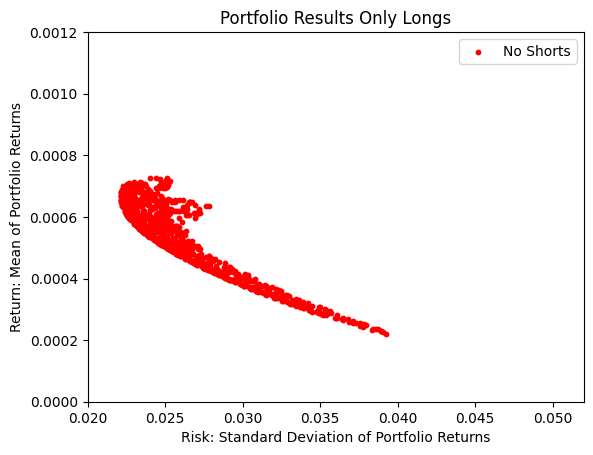

In [22]:
NO_SHORTS_PORTFOLIO_pd = NO_SHORTS_PORTFOLIO.to_pandas()
SHORTS_PORTFOLIO_pd = SHORTS_PORTFOLIO.to_pandas()

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(
    x=NO_SHORTS_PORTFOLIO_pd["sd_Return"],
    y=NO_SHORTS_PORTFOLIO_pd["expected_Return"],
    s=10,
    c="r",
    label="No Shorts",
)

# Add labels and title
plt.xlabel("Risk: Standard Deviation of Portfolio Returns")
plt.ylabel("Return: Mean of Portfolio Returns")
plt.title("Portfolio Results Only Longs")

plt.xlim(0.02, 0.052)
plt.ylim(0, 0.0012)
plt.legend()

# Display the plot
plt.show()

### Combined Plot

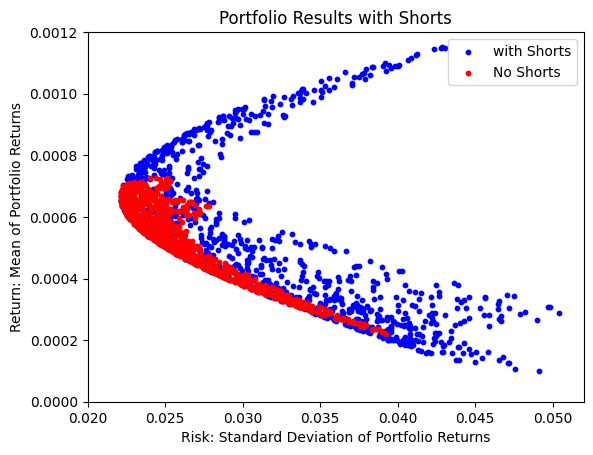

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(
    x=SHORTS_PORTFOLIO_pd["sd_Return"],
    y=SHORTS_PORTFOLIO_pd["expected_Return"],
    s=10,
    c="b",
    label="with Shorts",
)
ax1.scatter(
    x=NO_SHORTS_PORTFOLIO_pd["sd_Return"],
    y=NO_SHORTS_PORTFOLIO_pd["expected_Return"],
    s=10,
    c="r",
    label="No Shorts",
)

# Add labels and title
plt.xlabel("Risk: Standard Deviation of Portfolio Returns")
plt.ylabel("Return: Mean of Portfolio Returns")
plt.title("Portfolio Results with Shorts")

plt.xlim(0.02, 0.052)
plt.ylim(0, 0.0012)
plt.legend()

# Display the plot
plt.show()